In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device:", tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
import pandas as pd
import numpy as np

df = pd.read_excel("C:/Users/RAZER/Downloads/dataset/DS-Healthcare_version_2.xlsx")

In [11]:
#!pip install pandas
#!pip install openpyxl
#!pip install imbalanced-learn==0.7.0
#!pip install matplotlib
#!pip install seaborn
#!pip install lime
#!pip install shap
#!pip install -q flwr["simulation"]

     ------------------------------------ 167.1/167.1 kB 772.5 kB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.0
    Uninstalling imbalanced-learn-0.12.0:
      Successfully uninstalled imbalanced-learn-0.12.0


In [12]:
import math
from typing import Dict, List, Tuple
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import flwr as fl
from collections import Counter
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

VERBOSE = 0
NUM_CLIENTS = 50
count_rounds=0
number_of_rounds = 15
saving_model_name = ""


"""

#ANN
def get_model():

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[9]),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
    global saving_model_name,NUM_CLIENTS,number_of_rounds
    saving_model_name = str(NUM_CLIENTS)+"_"+str(number_of_rounds)+"_ann"
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


"""






#CNN

def get_model():

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu", input_shape=(9,)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(3, activation="softmax"),
  ])
  global saving_model_name,NUM_CLIENTS,number_of_rounds
  saving_model_name = str(NUM_CLIENTS)+"_"+str(number_of_rounds)+"cnn"
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model




"""

#LSTM
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation="relu", input_shape=(9, 1), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, activation="relu", return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation="softmax")
    ])
    global saving_model_name,NUM_CLIENTS,number_of_rounds
    saving_model_name = str(NUM_CLIENTS)+"_"+str(number_of_rounds)+"_lstm"

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

"""



"""
#Bi-LSTM

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu", return_sequences=True), input_shape=(9, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation="relu", return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation="relu")),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation="softmax")
    ])
    global saving_model_name, NUM_CLIENTS, number_of_rounds
    saving_model_name = str(NUM_CLIENTS) + "_" + str(number_of_rounds) + "_bi_lstm"

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model



"""


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, x_train, y_train, x_val, y_val) -> None:
        # Create model
        self.model = get_model()
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.x_train, self.y_train, epochs=1, batch_size=32, verbose=VERBOSE
        )
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(
            self.x_val, self.y_val, batch_size=64, verbose=VERBOSE
        )
        return loss, len(self.x_val), {"accuracy": acc}



def get_client_fn(dataset_partitions):
    """Return a function to be executed by the VirtualClientEngine in order to construct
    a client."""

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        x_train, y_train = dataset_partitions[int(cid)]
        # Use 10% of the client's training data for validation
        split_idx = math.floor(len(x_train) * 0.9)
        x_train_cid, y_train_cid = (
            x_train[:split_idx],
            y_train[:split_idx],
        )
        x_val_cid, y_val_cid = x_train[split_idx:], y_train[split_idx:]

        # Create and return client
        return FlowerClient(x_train_cid, y_train_cid, x_val_cid, y_val_cid)

    return client_fn





"""
#non balanced
def partition_dataset():
    encoder=LabelEncoder()
    df['Type']=encoder.fit_transform(df['Type'])
    X = df.iloc[:,4:]
    y = df['Type']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    testset = (x_test,y_test)
    print(type(x_train))
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(x_train) / NUM_CLIENTS)
    for cid in range(NUM_CLIENTS):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((x_train[idx_from:idx_to], y_train[idx_from:idx_to]))
    return partitions, testset


"""






#balanced
def partition_dataset():
    encoder = LabelEncoder()
    df['Type'] = encoder.fit_transform(df['Type'])
    X = df.iloc[:, 4:]
    y = df['Type']

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("Original dataset shape:", Counter(y))
    print("Resampled dataset shape:", Counter(y_resampled))

    x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0)
    print("y_train dataset shape:", Counter(y_train))
    print("y_test dataset shape:", Counter(y_test))

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    testset = (x_test, y_test)
    print(type(x_train))
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(x_train) / NUM_CLIENTS)
    for cid in range(NUM_CLIENTS):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((x_train[idx_from:idx_to], y_train[idx_from:idx_to]))
    return partitions, testset







def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    x_test, y_test = testset

    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test, verbose=VERBOSE)
        global count_rounds
        global number_of_rounds

        print("-------------------________________________---------------",number_of_rounds-count_rounds)

        if number_of_rounds-count_rounds == 0:
            global saving_model_name
            model.save(saving_model_name+"_model.h5")  # Replace with your desired filename"""

        count_rounds+=1
        return loss, {"accuracy": accuracy}

    return evaluate



# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create dataset partitions (needed if your dataset is not pre-partitioned)
partitions, testset = partition_dataset()

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)



# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}



# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=number_of_rounds),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)



import matplotlib.pyplot as plt

print(history.metrics_centralized)

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid(True)
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title(str(NUM_CLIENTS)+" clients with "+str(number_of_rounds)+" clients per round")

Original dataset shape: Counter({2: 581219, 1: 267360, 0: 40238})
Resampled dataset shape: Counter({2: 581219, 1: 581219, 0: 581219})


INFO flwr 2024-03-22 13:16:47,147 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)


y_train dataset shape: Counter({2: 389804, 1: 389288, 0: 389158})
y_test dataset shape: Counter({0: 192061, 1: 191931, 2: 191415})
<class 'numpy.ndarray'>


2024-03-22 13:16:51,284	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-22 13:16:54,008 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 10345436775.0, 'object_store_memory': 5172718387.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 20.0, 'GPU': 1.0}
INFO flwr 2024-03-22 13:16:54,008 | app.py:227 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-22 13:16:54,028 | app.py:274 | Flower VCE: Creating VirtualClientEngineActorPool with 20 actors
INFO flwr 2024-03-22 13:16:54,029 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-22 13:16:54,029 | server.py:276 | Requesting initial parameters from one random client
(DefaultActor pid=9400) 2024-03-22 13:17:03.997603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

-------------------________________________--------------- 15


(DefaultActor pid=24372) 2024-03-22 13:17:52.031968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
(DefaultActor pid=24372) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(DefaultActor pid=8380) 2024-03-22 13:17:52.470855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
(DefaultActor pid=8380) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(DefaultActor pid=24372) 2024-03-22 13:17:52.980019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12982 MB memory:  -> device: 0, name: NVIDI

-------------------________________________--------------- 14


DEBUG flwr 2024-03-22 13:19:15,980 | server.py:192 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:19:15,981 | server.py:227 | fit_round 2: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:19:28,645 | server.py:241 | fit_round 2 received 10 results and 0 failures
INFO flwr 2024-03-22 13:20:26,851 | server.py:131 | fit progress: (2, 0.6080098152160645, {'accuracy': 0.7270088791847229}, 155.62378990000002)
DEBUG flwr 2024-03-22 13:20:26,852 | server.py:178 | evaluate_round 2: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 13


DEBUG flwr 2024-03-22 13:20:30,420 | server.py:192 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:20:30,421 | server.py:227 | fit_round 3: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:20:43,485 | server.py:241 | fit_round 3 received 10 results and 0 failures
INFO flwr 2024-03-22 13:21:26,386 | server.py:131 | fit progress: (3, 0.5162836909294128, {'accuracy': 0.8292286992073059}, 215.15936850000003)
DEBUG flwr 2024-03-22 13:21:26,387 | server.py:178 | evaluate_round 3: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 12


DEBUG flwr 2024-03-22 13:21:29,278 | server.py:192 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:21:29,279 | server.py:227 | fit_round 4: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:21:41,835 | server.py:241 | fit_round 4 received 10 results and 0 failures
INFO flwr 2024-03-22 13:22:26,025 | server.py:131 | fit progress: (4, 0.4720686972141266, {'accuracy': 0.8201134204864502}, 274.7986697)
DEBUG flwr 2024-03-22 13:22:26,026 | server.py:178 | evaluate_round 4: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 11


DEBUG flwr 2024-03-22 13:22:29,851 | server.py:192 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:22:29,852 | server.py:227 | fit_round 5: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:22:43,292 | server.py:241 | fit_round 5 received 10 results and 0 failures
INFO flwr 2024-03-22 13:23:27,166 | server.py:131 | fit progress: (5, 0.44591113924980164, {'accuracy': 0.832577645778656}, 335.93865000000005)
DEBUG flwr 2024-03-22 13:23:27,168 | server.py:178 | evaluate_round 5: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 10


DEBUG flwr 2024-03-22 13:23:30,034 | server.py:192 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:23:30,035 | server.py:227 | fit_round 6: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:23:45,438 | server.py:241 | fit_round 6 received 10 results and 0 failures
INFO flwr 2024-03-22 13:24:31,853 | server.py:131 | fit progress: (6, 0.43555742502212524, {'accuracy': 0.8315070867538452}, 400.6266624)
DEBUG flwr 2024-03-22 13:24:31,853 | server.py:178 | evaluate_round 6: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 9


DEBUG flwr 2024-03-22 13:24:33,954 | server.py:192 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:24:33,955 | server.py:227 | fit_round 7: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:24:46,269 | server.py:241 | fit_round 7 received 10 results and 0 failures
INFO flwr 2024-03-22 13:25:28,298 | server.py:131 | fit progress: (7, 0.4301166832447052, {'accuracy': 0.831852912902832}, 457.0716841000001)
DEBUG flwr 2024-03-22 13:25:28,300 | server.py:178 | evaluate_round 7: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 8


DEBUG flwr 2024-03-22 13:25:30,347 | server.py:192 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:25:30,348 | server.py:227 | fit_round 8: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:25:42,727 | server.py:241 | fit_round 8 received 10 results and 0 failures
INFO flwr 2024-03-22 13:26:23,840 | server.py:131 | fit progress: (8, 0.40366336703300476, {'accuracy': 0.8513661026954651}, 512.6139495)
DEBUG flwr 2024-03-22 13:26:23,841 | server.py:178 | evaluate_round 8: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 7


DEBUG flwr 2024-03-22 13:26:25,742 | server.py:192 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:26:25,743 | server.py:227 | fit_round 9: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:26:37,969 | server.py:241 | fit_round 9 received 10 results and 0 failures
INFO flwr 2024-03-22 13:27:21,055 | server.py:131 | fit progress: (9, 0.3877299726009369, {'accuracy': 0.8571011424064636}, 569.8285421999999)
DEBUG flwr 2024-03-22 13:27:21,055 | server.py:178 | evaluate_round 9: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 6


DEBUG flwr 2024-03-22 13:27:23,055 | server.py:192 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:27:23,057 | server.py:227 | fit_round 10: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:27:35,821 | server.py:241 | fit_round 10 received 10 results and 0 failures
INFO flwr 2024-03-22 13:28:17,061 | server.py:131 | fit progress: (10, 0.374532550573349, {'accuracy': 0.8594611883163452}, 625.8347865000001)
DEBUG flwr 2024-03-22 13:28:17,062 | server.py:178 | evaluate_round 10: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 5


DEBUG flwr 2024-03-22 13:28:19,281 | server.py:192 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:28:19,282 | server.py:227 | fit_round 11: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:28:31,800 | server.py:241 | fit_round 11 received 10 results and 0 failures
INFO flwr 2024-03-22 13:29:12,442 | server.py:131 | fit progress: (11, 0.36242836713790894, {'accuracy': 0.8683279752731323}, 681.2155167999999)
DEBUG flwr 2024-03-22 13:29:12,443 | server.py:178 | evaluate_round 11: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 4


DEBUG flwr 2024-03-22 13:29:14,844 | server.py:192 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:29:14,844 | server.py:227 | fit_round 12: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:29:27,196 | server.py:241 | fit_round 12 received 10 results and 0 failures
INFO flwr 2024-03-22 13:30:09,780 | server.py:131 | fit progress: (12, 0.35721638798713684, {'accuracy': 0.865552544593811}, 738.5535864000001)
DEBUG flwr 2024-03-22 13:30:09,786 | server.py:178 | evaluate_round 12: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 3


DEBUG flwr 2024-03-22 13:30:12,582 | server.py:192 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:30:12,583 | server.py:227 | fit_round 13: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:30:24,896 | server.py:241 | fit_round 13 received 10 results and 0 failures
INFO flwr 2024-03-22 13:31:08,072 | server.py:131 | fit progress: (13, 0.3490435481071472, {'accuracy': 0.8727439641952515}, 796.8448012000001)
DEBUG flwr 2024-03-22 13:31:08,072 | server.py:178 | evaluate_round 13: strategy sampled 5 clients (out of 50)


-------------------________________________--------------- 2


DEBUG flwr 2024-03-22 13:31:10,337 | server.py:192 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-03-22 13:31:10,338 | server.py:227 | fit_round 14: strategy sampled 10 clients (out of 50)
DEBUG flwr 2024-03-22 13:31:22,818 | server.py:241 | fit_round 14 received 10 results and 0 failures


In [5]:
print(history.metrics_centralized)

history.metrics_centralized = {'accuracy': [(0, 0.3335551917552948), (1, 0.6531029343605042), (2, 0.7369322776794434), (3, 0.8208729028701782), (4, 0.8155549168586731), (5, 0.8480345010757446), (6, 0.8493935465812683), (7, 0.8563729524612427), (8, 0.8620715141296387), (9, 0.8700050711631775), (10, 0.8722087144851685), (11, 0.8710339069366455), (12, 0.8715622425079346), (13, 0.8735243082046509), (14, 0.8801769614219666), (15, 0.8853611350059509)]}


# Evaluation

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


def eva(loaded_model):
    x_test, y_test = testset
    loss, accuracy = loaded_model.evaluate(x_test, y_test)
    print("Accuracy:", accuracy)
    print("Loss:", loss)

    predicted_probabilities = loaded_model.predict(x_test)
    predictions = predicted_probabilities.argmax(axis=-1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1_score)

    # Confusion Matrix evaluation
    conf_matrix = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:\n", conf_matrix)
    class_names = ['arrhythmic', 'healthy', 'ischemic']
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font scale for overall figure

    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                     xticklabels=class_names,
                     yticklabels=class_names)
    plt.xlabel("Predicted Labels", labelpad=10, fontsize=14, fontweight='bold')
    plt.ylabel("True Labels", labelpad=10, fontsize=14, fontweight='bold')
    plt.title("Confusion Matrix", fontsize=16, fontweight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')

    plt.show()



def ROC(loaded_model):
    x_test, y_test = testset
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_one_hot = lb.transform(y_test)

    # Get the predicted probabilities for each class
    predicted_probabilities = loaded_model.predict(x_test)

    # Compute the ROC curve and AUC score for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC score
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), predicted_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(12, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # Class names mapping
    class_names = ['arrhythmic', 'healthy', 'ischemic']

    for i in range(len(lb.classes_)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Make the grid more dense
    plt.grid(True, linewidth=0.5, alpha=0.5)
    plt.show()


## Load Model

In [17]:
from tensorflow.keras.models import load_model
loaded_model = load_model("50_15cnn_model.h5")

17982/17982 [==============================] - 17s 930us/step - loss: 0.3296 - accuracy: 0.8778
Accuracy: 0.8778343200683594
Loss: 0.3296278119087219
17982/17982 [==============================] - 15s 852us/step
Precision: 0.8853406604383086
Recall: 0.8778342981576519
F1-Score: 0.8767782721984161
Confusion Matrix:
 [[172112  15873   4076]
 [  5732 184682   1517]
 [ 27276  15821 148318]]


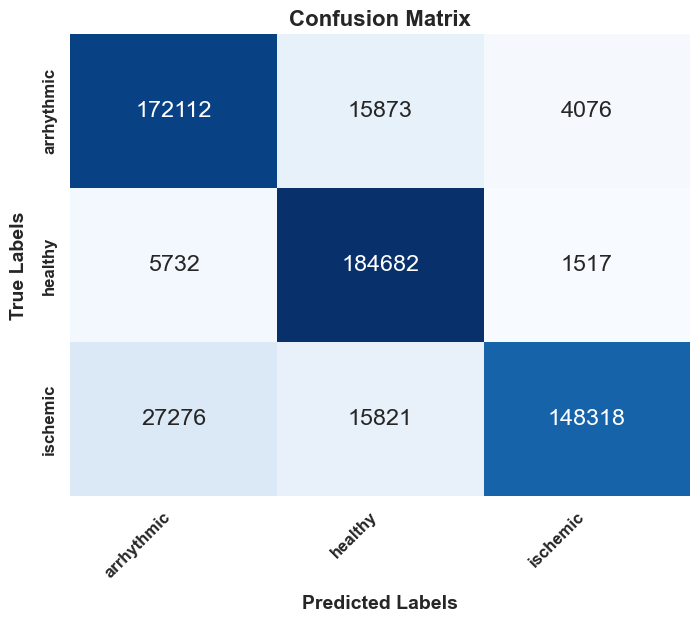

In [18]:
eva(loaded_model)

17982/17982 [==============================] - 15s 837us/step


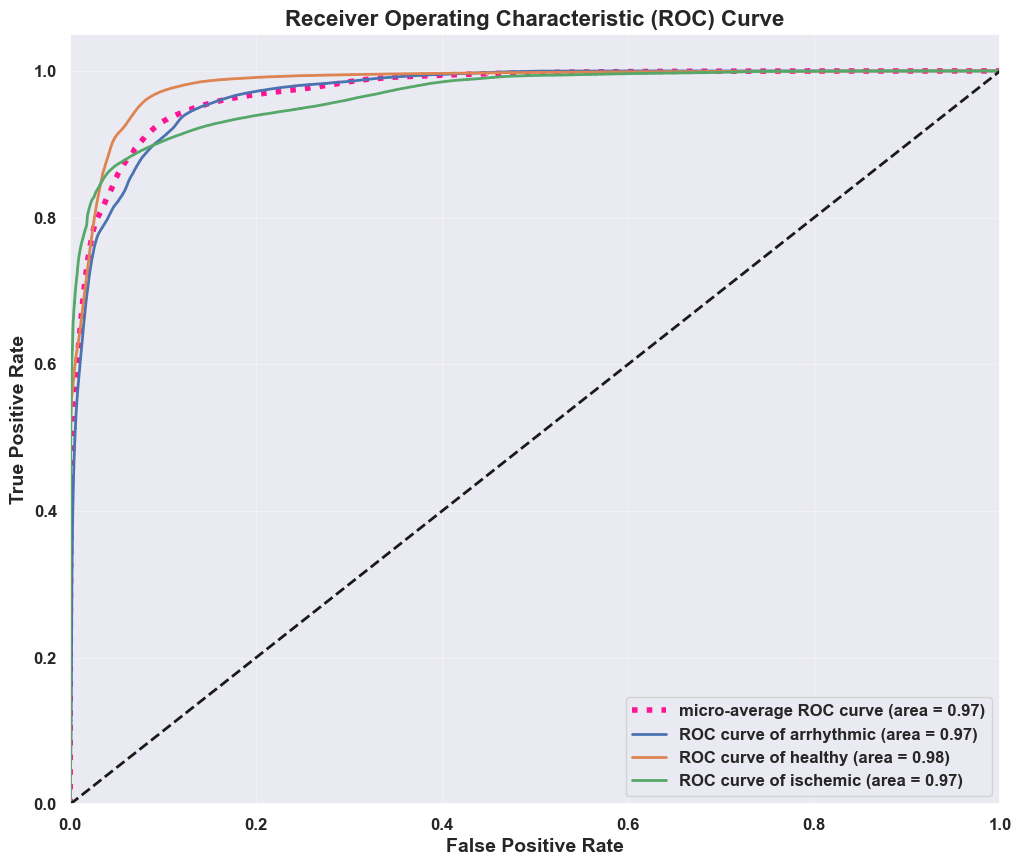

In [19]:
ROC(loaded_model)

# LIME


## Load Model

In [23]:
import tensorflow as tf
model_path = '50_15cnn_model.h5'
model = tf.keras.models.load_model(model_path)


In [24]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular
import numpy as np
import tensorflow as tf



encoder=LabelEncoder()
df['Type']=encoder.fit_transform(df['Type'])
X = df.iloc[:,4:]
y = df['Type']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)




explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names= ['arrhythmic', 'healthy', 'ischemic'],
)


# Select an instance to explain
instance_index = 1
instance = np.array(x_test)[instance_index]

# Define a prediction function that LIME can use
def predict_function(x):
    return model.predict(x).astype(float)

# Generate explanations
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_function,
    num_features=9,
    top_labels=3
)



# Visualize the explanation for a specific class
exp.show_in_notebook(show_table=True, show_all=True)


from IPython.display import HTML
html_data = exp.as_html()
HTML(data=html_data)

exp.save_to_file("LIME.html")

157/157 [==============================] - 0s 1ms/step


c:\Users\RAZER\anaconda3\envs\Fer-de-lance\lib\site-packages\lime\explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# SHAP

In [25]:
import tensorflow as tf
model_path = '50_15cnn_model.h5'
model = tf.keras.models.load_model(model_path)

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


encoder=LabelEncoder()
df['Type']=encoder.fit_transform(df['Type'])
X = df.iloc[:,4:]
y = df['Type']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)




encoder=LabelEncoder()
df['Type']=encoder.fit_transform(df['Type'])
X = df.iloc[:,4:]
y = df['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)



import shap

background = X_test[0:500]
forground = X_test[:25]

explainer = shap.KernelExplainer(model.predict,background)

shap_values = explainer.shap_values(forground)

# Now, create an Explanation object
expl = shap.Explanation(values=shap_values[0],
                        base_values=explainer.expected_value,
                        data=forground, # Adjust based on your actual test set
                        feature_names=X_train.columns)


 1/16 [>.............................] - ETA: 0s

c:\Users\RAZER\anaconda3\envs\Fer-de-lance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


16/16 [==============================] - 0s 974us/step


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/25 [00:00<?, ?it/s]

7969/7969 [==============================] - 7s 836us/step


c:\Users\RAZER\anaconda3\envs\Fer-de-lance\lib\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
  4%|▍         | 1/25 [00:09<03:42,  9.26s/it]

7969/7969 [==============================] - 7s 867us/step


  8%|▊         | 2/25 [00:18<03:28,  9.06s/it]

7969/7969 [==============================] - 7s 862us/step


 12%|█▏        | 3/25 [00:27<03:17,  8.99s/it]

7969/7969 [==============================] - 7s 864us/step


 16%|█▌        | 4/25 [00:36<03:08,  8.97s/it]

7969/7969 [==============================] - 7s 893us/step


 20%|██        | 5/25 [00:45<03:01,  9.07s/it]

7969/7969 [==============================] - 7s 868us/step


 24%|██▍       | 6/25 [00:54<02:51,  9.01s/it]

7969/7969 [==============================] - 7s 896us/step


 28%|██▊       | 7/25 [01:03<02:42,  9.04s/it]

7969/7969 [==============================] - 7s 902us/step


 32%|███▏      | 8/25 [01:12<02:34,  9.06s/it]

7969/7969 [==============================] - 7s 891us/step


 36%|███▌      | 9/25 [01:21<02:25,  9.07s/it]

7969/7969 [==============================] - 7s 871us/step


 40%|████      | 10/25 [01:30<02:15,  9.03s/it]

7969/7969 [==============================] - 7s 877us/step


 44%|████▍     | 11/25 [01:39<02:06,  9.02s/it]

7969/7969 [==============================] - 7s 852us/step


 48%|████▊     | 12/25 [01:48<01:56,  8.94s/it]

7969/7969 [==============================] - 7s 873us/step


 52%|█████▏    | 13/25 [01:57<01:47,  8.94s/it]

7969/7969 [==============================] - 7s 858us/step


 56%|█████▌    | 14/25 [02:05<01:37,  8.89s/it]

7969/7969 [==============================] - 7s 896us/step


 60%|██████    | 15/25 [02:14<01:29,  8.96s/it]

7969/7969 [==============================] - 7s 853us/step


 64%|██████▍   | 16/25 [02:23<01:20,  8.91s/it]

7969/7969 [==============================] - 7s 881us/step


 68%|██████▊   | 17/25 [02:32<01:11,  8.92s/it]

7969/7969 [==============================] - 7s 874us/step


 72%|███████▏  | 18/25 [02:41<01:02,  8.95s/it]

7969/7969 [==============================] - 7s 864us/step


 76%|███████▌  | 19/25 [02:50<00:53,  8.93s/it]

7969/7969 [==============================] - 7s 868us/step


 80%|████████  | 20/25 [02:59<00:44,  8.91s/it]

7969/7969 [==============================] - 7s 850us/step


 84%|████████▍ | 21/25 [03:08<00:35,  8.89s/it]

7969/7969 [==============================] - 7s 833us/step


 88%|████████▊ | 22/25 [03:16<00:26,  8.80s/it]

7969/7969 [==============================] - 7s 835us/step


 92%|█████████▏| 23/25 [03:25<00:17,  8.77s/it]

7969/7969 [==============================] - 7s 850us/step


 96%|█████████▌| 24/25 [03:34<00:08,  8.76s/it]

7969/7969 [==============================] - 7s 867us/step


100%|██████████| 25/25 [03:43<00:00,  8.94s/it]


## Local Explanation

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], forground)

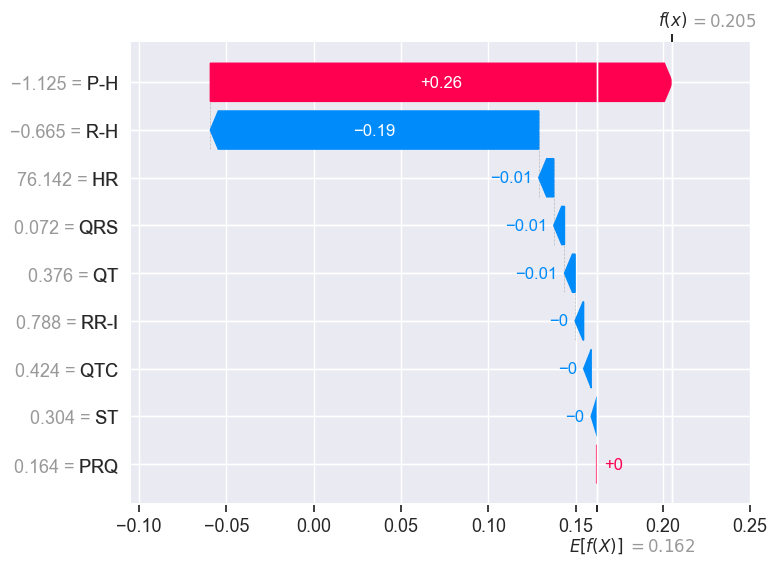

In [28]:
shap.initjs()
expl = shap.Explanation(values=shap_values[..., 0],
                        base_values=explainer.expected_value,
                        data=forground,
                        feature_names=X_train.columns)

shap.plots.waterfall(expl[0])

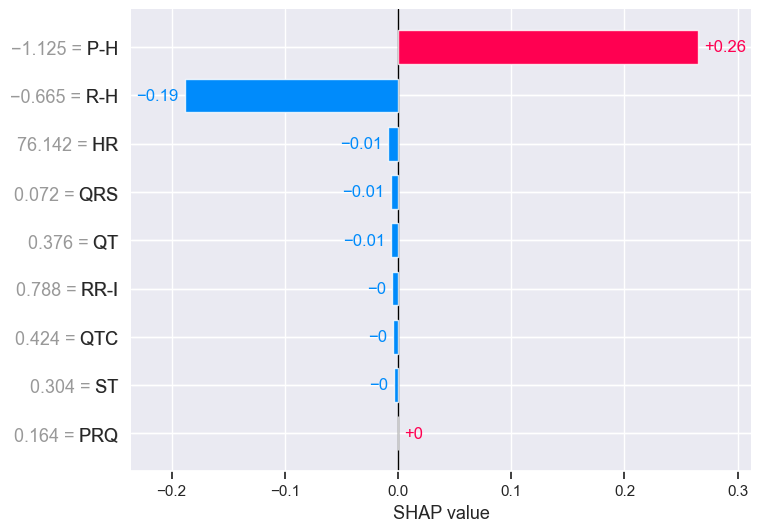

In [29]:
shap.initjs()
shap.plots.bar(expl[0])

## Global Explnation

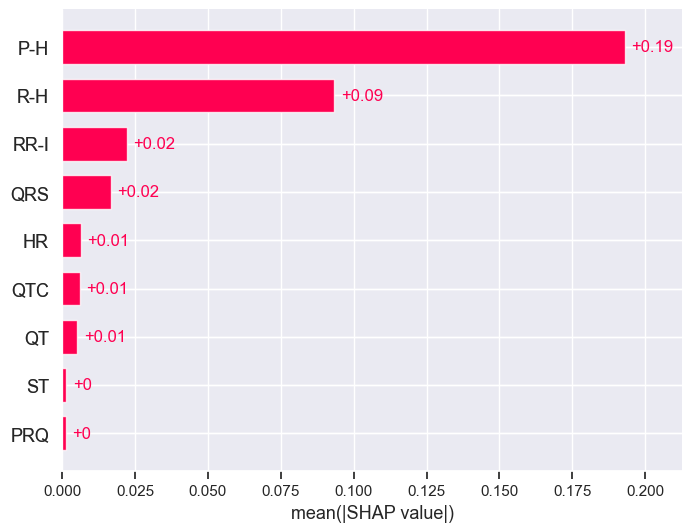

In [30]:
shap.initjs()
shap.plots.bar(expl)

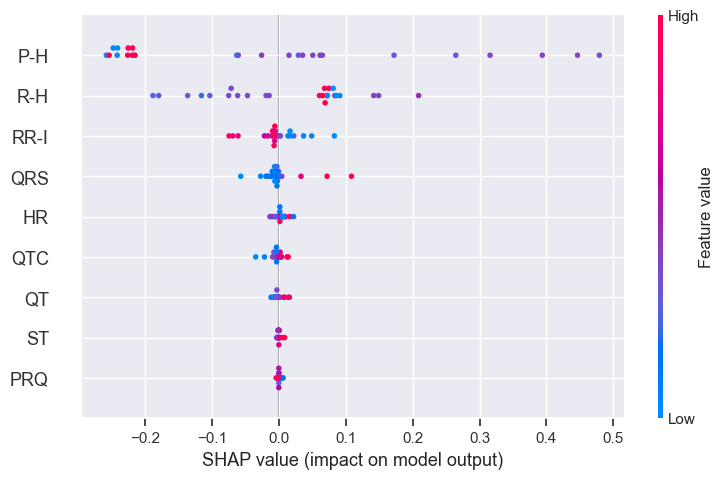

In [31]:
shap.initjs()
shap.summary_plot(expl)